### *partial codes and functions are refenrecing from Jona5's notebook https://www.kaggle.com/jona5d

In [296]:
#1 - Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import scipy.stats as stat
from sklearn.metrics import r2_score
from sklearn import metrics
import math
import os

print(os.listdir("../../data/external"))

['.DS_Store', '.gitkeep', 'nyc-rolling-sales.csv']


In [300]:
#2 - Load file into dataframe
df = pd.read_csv("../../data/model/clean.csv")

In [301]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,price,land,gross_sqft,year
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,6440,1900,2,C2,6625000,2017-07-19 00:00:00,15.706361,1633.0,6440.0,1900.0
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,6794,1913,2,C4,3936272,2016-09-23 00:00:00,15.185745,2272.0,6794.0,1913.0
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,4615,1900,2,C2,8000000,2016-11-17 00:00:00,15.894952,2369.0,4615.0,1900.0
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,,C4,210 AVENUE B,,...,4226,1920,2,C4,3192840,2016-09-23 00:00:00,14.976421,1750.0,4226.0,1920.0
4,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,,D9,629 EAST 5TH STREET,,...,18523,1920,2,D9,16232000,2016-11-07 00:00:00,16.602495,4489.0,18523.0,1920.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58543,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,,B9,37 QUAIL LANE,,...,2575,1998,1,B9,450000,2016-11-28 00:00:00,13.017003,2400.0,2575.0,1998.0
58544,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,,B9,32 PHEASANT LANE,,...,2377,1998,1,B9,550000,2017-04-21 00:00:00,13.217674,2498.0,2377.0,1998.0
58545,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7351,60,,B2,49 PITNEY AVENUE,,...,1496,1925,1,B2,460000,2017-07-05 00:00:00,13.038982,4000.0,1496.0,1925.0
58546,5,WOODROW,22 STORE BUILDINGS,4,7100,28,,K6,2730 ARTHUR KILL ROAD,,...,64117,2001,4,K6,11693337,2016-12-21 00:00:00,16.274530,208033.0,64117.0,2001.0


In [302]:
#Overview of data
#Find no. of rows & cols
print(df.shape, "\n")
#Show col names and datatypes
print(df.dtypes, "\n")
#Show no. of None values
print(df.isna().sum(), "\n")

(58548, 25) 

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING CLASS CATEGORY            object
TAX CLASS AT PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                          object
BUILDING CLASS AT PRESENT          object
ADDRESS                            object
APARTMENT NUMBER                   object
ZIP CODE                            int64
RESIDENTIAL UNITS                   int64
COMMERCIAL UNITS                    int64
TOTAL UNITS                         int64
LAND SQUARE FEET                   object
GROSS SQUARE FEET                  object
YEAR BUILT                          int64
TAX CLASS AT TIME OF SALE           int64
BUILDING CLASS AT TIME OF SALE     object
SALE PRICE                          int64
SALE DATE                          object
price                             float64
land                              float64
gross_sqft          

In [262]:
#3 - Functions for data exploration

#Function for plotting histograms:
def PlotHist(col, color='b'):
    col.plot.hist(grid=True, bins=12, rwidth=0.9,
                      color=color)
    plt.title('Value distribution: ' + col.name)
    plt.xlabel(col.name)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show();
    
#Calculate step for y-ticks
def CalcMax(max_val):
    mag = len(str(round(max_val))) - 1
    #power of ten - pot
    PoT = 10 ** mag 
    rounded = math.ceil(max_val/PoT) * PoT
    return rounded;

#Function for selecting categories
def AssignCat(col, num_cats=5):
    if len(col.value_counts().keys()) < num_cats:
        num_cats = len(col.value_counts().keys())
    cats =  pd.DataFrame(col.value_counts().nlargest(num_cats - 1))
    cats['row_num'] = [str(x+1) for x in range(len(cats))]
    cats['name'] = cats.index.values
    col = pd.DataFrame({'val': col.values})
    col = pd.merge(col, cats, how='left', left_on='val', right_on='name')
    col['new'] = col['row_num'].fillna(str(num_cats))
    return col['new'].values;
 
#Function for plotting bar charts:
def PlotBar(col, color='b'):
    means = {}
    for i in col.unique():
        means.update({i : np.exp(df['Price'][df[col.name]== i]).mean()})   
    plt.bar(range(len(means)), list(means.values()), align='center', \
            color=color)
    plt.xticks(range(len(means)), sorted(list(means.keys())))
    #Get largest value
    maximum = CalcMax(max(means.values()))
    s = maximum / 5
    y_labels = ["{:,}".format(x) for x in np.arange(0,maximum, step=s)]
    plt.yticks(np.arange(0,maximum, step=s),y_labels)
    plt.title('Avg. Price per ' + col.name)
    plt.xlabel(col.name)
    plt.ylabel('Price')
    plt.show(); 
    
#Function for creating scatter plots:
def PlotScatter(col, show='none'):
    plt.title('Price - ' + col.name)
    plt.xlabel(col.name)
    plt.ylabel('Price log')
    if show == 'mlp':
        plt.scatter(col,(df['Price']))
        plt.show()
    elif show == 'sns': 
        sns.regplot(x=col.name, y='Price', data=df, x_jitter=.5)
        plt.show()
    else: print(col.name +': No plot shown to reduce processing time');

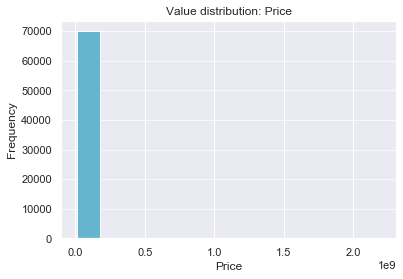

In [263]:
#4 - Analyse dependent variable

# #Check for unusual values
# df['Price'] = sorted(df['SALE PRICE'])
# #print(df.Price.head(10))

#Some values which represent missing values: '-'
#Convert to int
df['Price'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')

#remove Nan values
df = df[df['Price'].isnull()==0]

# df['Price'] = df['Price'].astype(int)
# Show distribution before transformation
PlotHist(df['Price'],'c')

count     59759
unique    10006
top          10
freq        766
Name: SALE PRICE, dtype: object 

Average Price (log): 13 

Std. Dev. of Price (log): 2 



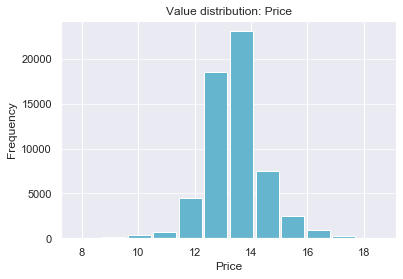

In [264]:
#Remove records with price = 0 - Anomalies
df = df[df['Price'] != 0]

df['Price'] = df['Price'].apply(np.log)

print(df['SALE PRICE'].describe(), "\n")
price_avg = df['Price'].mean()
print('Average Price (log): ' + "{:,}".format(round(price_avg)), "\n")
price_stdev = np.std(df['Price'])
print('Std. Dev. of Price (log): ' + "{:,}".format(round(price_stdev)), "\n")

#Remove outliers: 3 stdevs from mean
df =  df[df['Price'] >= price_avg - price_stdev * 3]
df =  df[df['Price'] <= price_avg + price_stdev * 3]

#Plot again:
PlotHist(df['Price'], 'c')

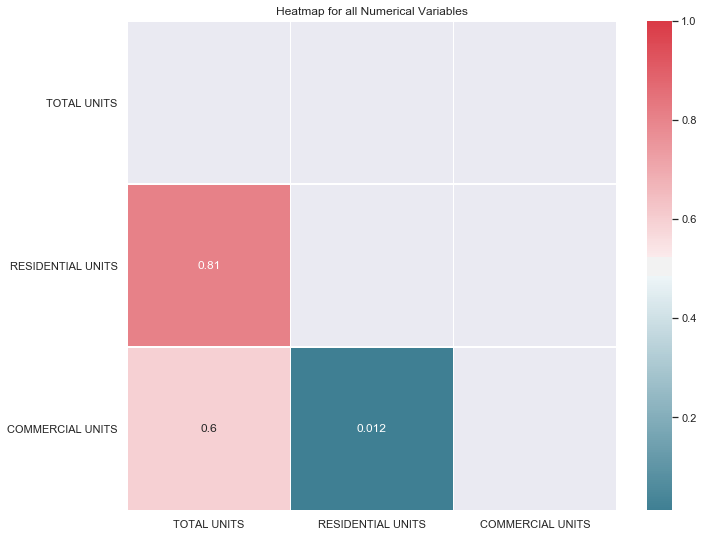

In [206]:
#Compute the correlation matrix
d= df[['TOTAL UNITS','GROSS SQUARE FEET','SALE PRICE', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS', 
         'COMMERCIAL UNITS']]

corr = d.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, 
            square=True, linewidths=.5, annot=True, cmap=cmap)
plt.yticks(rotation=0)
plt.title('Heatmap for all Numerical Variables')
plt.show()

In [207]:
# #5 - Explore independent variables

# #1. Borough
# print('BOROUGH - Value Counts')
# print(df.BOROUGH.value_counts(), "\n")
# PlotBar(df['BOROUGH'],'g')

# #Convert to dummies
# borough = pd.get_dummies(df['BOROUGH'], prefix='borough')
# df = pd.concat([df, borough], axis=1)

# # May use this feature in multiple regression due to significant price difference

# #2. Neighborhood
# #print('NEIGHBORHOOD - Value Counts')
# #print(df.NEIGHBORHOOD.value_counts(), "\n")
# # Probably not useful: too many distinct, non-numeric values

# #3. Building Class Category
# #Since there are too many categories, we only take the first 4 categories 
# #and group the rest into one
# df['building_category'] = AssignCat(df['BUILDING CLASS CATEGORY'])

# PlotBar(df['building_category'],'r')

# #Convert to dummies
# build_cat = pd.get_dummies(df['building_category'], prefix='bc')
# df = pd.concat([df, build_cat], axis=1)

# #4.A Tax Class Category
# print('Tax Class - Value Counts')
# print(df['TAX CLASS AT PRESENT'].value_counts(), "\n")
# #Only use 3 most common classes
# df['tax_class'] = AssignCat(df['TAX CLASS AT PRESENT'])

# PlotBar(df['tax_class'],'gray')

# #Convert to dummies
# tax_class = pd.get_dummies(df['tax_class'], prefix='tc')
# df = pd.concat([df, tax_class], axis=1)

# #4.B Tax class at time of sale
# print('Tax Class at Sale - Value Counts')
# print(df['TAX CLASS AT TIME OF SALE'].value_counts(), "\n")
# #Only use 3 most common classes
# df['tc_at_sale'] = AssignCat(df['TAX CLASS AT TIME OF SALE'])
  

# PlotBar(df['tax_class'],'black')

# tc_present = pd.get_dummies(df['tc_at_sale'], prefix='tcs')
# df = pd.concat([df, tc_present], axis=1)

# #Different systems - unclear which is better

# #5. Block
# #print('Block - Value Counts')
# #print(df['BLOCK'].value_counts(), "\n")
# #Too many distinct values, no category with significant % of counts

# #6. Lot
# #print('Lot - Value Counts')
# #print(df['LOT'].value_counts(), "\n")
# #Too many distinct values, no category with significant % of counts

# #7. Ease-ment
# print('Ease-ment - Value Counts')
# print(df['EASE-MENT'].value_counts(), "\n")
# #Same as ID - no use

# #8A - Building class at present
# #print('Building Class Present - Value Counts')
# #print(df['BUILDING CLASS AT PRESENT'].value_counts(), "\n")
# #Only use 3 most common classes
# df['bcp'] = AssignCat(df['BUILDING CLASS AT PRESENT'])

# PlotBar(df['bcp'],color='y')

# #8B - Building class at time of sale


# df['bcs'] = AssignCat(df['BUILDING CLASS AT TIME OF SALE'])

# PlotBar(df['bcs'],color='coral')

# #Almost the same as Building Class at Present - use at Sale which is more meaningful

# bcs = pd.get_dummies(df['bcs'], prefix='bcs')
# df = pd.concat([df, bcs], axis=1)

# #9. Address
# #Too specifig - unlikely to be useful

# #10. Apartment no.
# #print('Apartment No. - Value Counts')
# #print(df['APARTMENT NUMBER'].value_counts(), "\n")
# #Too many different values 

# #11. Zip code
# #print('ZIP Code - Value Counts')
# #print(df['ZIP CODE'].value_counts(), "\n")
# #Too many different values 


# #12. Residential units
# #print('RESIDENTIAL UNITS - Value Counts')
# #print(df['RESIDENTIAL UNITS'].value_counts(), "\n")
# df['res_unit_log'] = df['RESIDENTIAL UNITS'].apply(lambda x: 0 if x == 0 \
#                                               else np.log(x)) 
# PlotScatter(df['res_unit_log'])

# #13. Commercial units
# df['com_unit_log'] = df['COMMERCIAL UNITS'].apply(lambda x: 0 if x == 0 \
#                                               else np.log(x)) 
# PlotScatter(df['com_unit_log'])

# #14. Total units
# df['tot_unit_log'] = df['TOTAL UNITS'].apply(lambda x: 0 if x == 0 \
#                                               else np.log(x)) 
# PlotScatter(df['tot_unit_log'])

# #15. Land square ft
# #Impute mean for missing and values
# df['land'] =  pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
# #use median for 0 and nulls
# land_median = df['land'][df['land']!=0].median()
# df['land'] = df['land'].fillna(land_median)
# df['land'] = df['land'].apply(lambda x: x if x > 0 \
#                                           else land_median)
# df['land_log'] = np.log(df['land'])
# PlotScatter(df['land_log'])

# #16. Gross square ft
# df['gross_sqft'] =  pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
# #use median for 0 and nulls
# gross_sqft_median = df['gross_sqft'][df['gross_sqft']!=0].median()
# df['gross_sqft'] = df['gross_sqft'].fillna(gross_sqft_median)
# df['gross_sqft'] = df['gross_sqft'].apply(lambda x: x if x > 0 \
#                                           else gross_sqft_median)
# df['gross_sqft_log'] = np.log(df['gross_sqft'])
# PlotScatter(df['gross_sqft'])

# #17. Year built
# df['year'] = df['YEAR BUILT']
# #Impute median where year = 0
# year_median = df['year'][df['year'] != 0].median()
# #Date cannot before 1764
# df['year'] = df['year'].apply(lambda x: x if x >= 1764 else year_median )
# PlotHist(df['year'], 'orange')
# PlotScatter(df['year'])

# #Unclear if relationship between year and price


# #18. Sale date
# df['date'] = pd.to_datetime(df['SALE DATE'], format = '%Y-%m-%d %H:%M:%S') 

# sale_dates =  sorted(set(df['date']))

# date_means = []
# for i in sale_dates:
#     date_means.append(np.exp(df['Price'][df['date']== i]).mean())
    
# plt.plot(sale_dates,date_means)
# plt.title('Price - Sale Date')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()
# #Apparently no clear relationship

BOROUGH - Value Counts
4    18092
3    15323
1    14271
5     5855
2     5007
Name: BOROUGH, dtype: int64 



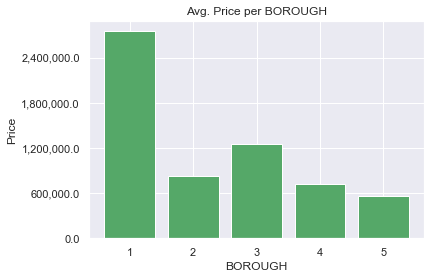

In [208]:
#5 - Explore independent variables

#1. Borough
print('BOROUGH - Value Counts')
print(df.BOROUGH.value_counts(), "\n")
PlotBar(df['BOROUGH'],'g')

In [209]:
#2. Neighborhood
print('NEIGHBORHOOD - Value Counts')
print(df.NEIGHBORHOOD.value_counts(), "\n")
#Probably not useful: too many distinct, non-numeric values

NEIGHBORHOOD - Value Counts
FLUSHING-NORTH              2163
UPPER EAST SIDE (59-79)     1459
UPPER EAST SIDE (79-96)     1312
UPPER WEST SIDE (59-79)     1077
MIDTOWN EAST                1064
                            ... 
FRESH KILLS                    2
VAN CORTLANDT PARK             2
CITY ISLAND-PELHAM STRIP       1
EAST RIVER                     1
BRONX PARK                     1
Name: NEIGHBORHOOD, Length: 253, dtype: int64 



In [265]:
#3. Building Class Category
#Since there are too many categories, we only take the first 4 categories 
#and group the rest into one
print('Building Class - Value Counts')
print(df['BUILDING CLASS CATEGORY'].value_counts().head(4), "\n")

df['bc'] = AssignCat(df['BUILDING CLASS CATEGORY'])

#PlotBar(df['building_category'],'r')

# #Convert to dummies
# build_cat = pd.get_dummies(df['building_category'], prefix='bc')
# df = pd.concat([df, build_cat], axis=1)

Building Class - Value Counts
01 ONE FAMILY DWELLINGS                        12690
10 COOPS - ELEVATOR APARTMENTS                 11520
13 CONDOS - ELEVATOR APARTMENTS                10264
02 TWO FAMILY DWELLINGS                         9849
Name: BUILDING CLASS CATEGORY, dtype: int64 



In [211]:
df['bc'].value_counts()

5    14225
1    12690
2    11520
3    10264
4     9849
Name: bc, dtype: int64

Tax Class - Value Counts
2     25678
1     24915
4      2465
2C     1542
2A     1252
1A     1092
        592
1B      483
2B      399
1C      130
Name: TAX CLASS AT PRESENT, dtype: int64 



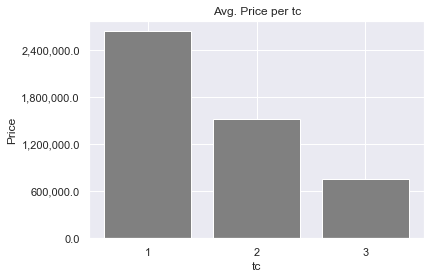

In [212]:
#4.A Tax Class Category
#Only use 2 most common classes, group the rest into one group
print('Tax Class - Value Counts')
print(df['TAX CLASS AT PRESENT'].value_counts(), "\n")

df['tc'] = AssignCat(df['TAX CLASS AT PRESENT'],3)

PlotBar(df['tc'],'gray')

# #Convert to dummies
# tax_class = pd.get_dummies(df['tax_class'], prefix='tc')
# df = pd.concat([df, tax_class], axis=1)

In [213]:
df['tc'].value_counts()

1    25678
2    24915
3     7955
Name: tc, dtype: int64

Tax Class at Sale - Value Counts
2    29413
1    26644
4     2491
Name: TAX CLASS AT TIME OF SALE, dtype: int64 



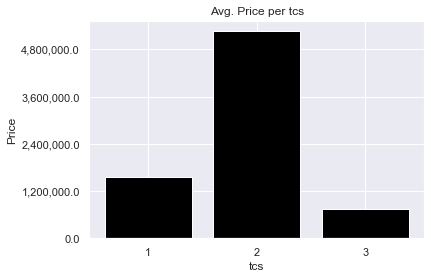

In [214]:
#4.B Tax class at time of sale
print('Tax Class at Sale - Value Counts')
print(df['TAX CLASS AT TIME OF SALE'].value_counts(), "\n")
#Only use 3 most common classes
df['tcs'] = AssignCat(df['TAX CLASS AT TIME OF SALE'])
  

PlotBar(df['tcs'],'black')

# tc_present = pd.get_dummies(df['tc_at_sale'], prefix='tcs')
# df = pd.concat([df, tc_present], axis=1)

#Different systems - unclear which is better

In [215]:
df['TAX CLASS AT TIME OF SALE'].unique()

array([2, 4, 1])

In [216]:
df['tcs'].value_counts()

1    29413
2    26644
3     2491
Name: tcs, dtype: int64

In [217]:
#5. Block
print('Block - Value Counts')
print(df['BLOCK'].value_counts(), "\n")
#Too many distinct values, no category with significant % of counts

Block - Value Counts
5066    388
16      202
2135    196
4978    181
170     131
       ... 
7270      1
2333      1
4948      1
9994      1
4094      1
Name: BLOCK, Length: 10484, dtype: int64 



In [218]:
#6. Lot
print('Lot - Value Counts')
print(df['LOT'].value_counts(), "\n")
#Too many distinct values, no category with significant % of counts

Lot - Value Counts
1       3304
20       690
12       680
40       662
23       638
        ... 
586        1
2603       1
554        1
2539       1
1999       1
Name: LOT, Length: 2356, dtype: int64 



In [219]:
#7. Ease-ment
print('Ease-ment - Value Counts')
print(df['EASE-MENT'].value_counts(), "\n")
#Same as ID - no use

Ease-ment - Value Counts
     58548
Name: EASE-MENT, dtype: int64 



Building Class Present - Value Counts
D4    11311
R4     9776
A1     4729
A5     4071
Name: BUILDING CLASS AT PRESENT, dtype: int64 



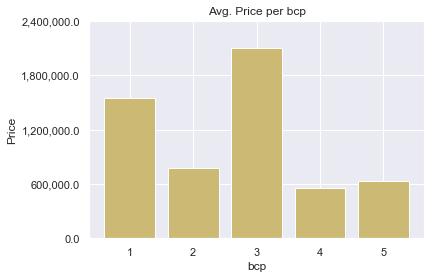

In [220]:
#8A - Building class at present
print('Building Class Present - Value Counts')
print(df['BUILDING CLASS AT PRESENT'].value_counts().head(4), "\n")
#Only use 3 most common classes
df['bcp'] = AssignCat(df['BUILDING CLASS AT PRESENT'])

PlotBar(df['bcp'],color='y')

In [221]:
df['bcp'].value_counts()

5    28661
1    11311
2     9776
3     4729
4     4071
Name: bcp, dtype: int64

In [222]:
df['bcp']

0        5
3        5
4        5
6        5
9        5
        ..
84543    5
84544    5
84545    5
84546    5
84547    5
Name: bcp, Length: 58548, dtype: object

Building Class at Sale - Value Counts
D4    11313
R4    10264
A1     4727
A5     4058
Name: BUILDING CLASS AT TIME OF SALE, dtype: int64 



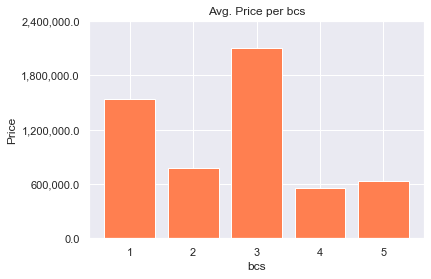

In [223]:
#8B - Building class at time of sale
print('Building Class at Sale - Value Counts')
print(df['BUILDING CLASS AT TIME OF SALE'].value_counts().head(4), "\n")

df['bcs'] = AssignCat(df['BUILDING CLASS AT TIME OF SALE'])

PlotBar(df['bcs'],color='coral')

#Almost the same as Building Class at Present - use at Sale which is more meaningful

bcs = pd.get_dummies(df['bcs'], prefix='bcs')
df = pd.concat([df, bcs], axis=1)

In [224]:
df[df['bcp']=='1']

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,bc,tc,tcs,bcp,bcs,bcs_1,bcs_2,bcs_3,bcs_4,bcs_5
72,1,ALPHABET CITY,10 COOPS - ELEVATOR APARTMENTS,2,386,58,,D4,"223 EAST 3RD STREET, 2D",,...,2,1,1,1,1,1,0,0,0,0
324,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,2,694,42,,D4,"520 WEST 23RD STREET, 16C",,...,2,1,1,1,1,1,0,0,0,0
325,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,2,694,42,,D4,"520 WEST 23RD STREET, 14D",,...,2,1,1,1,1,1,0,0,0,0
326,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,2,694,42,,D4,"520 WEST 23RD STREET, 8C",,...,2,1,1,1,1,1,0,0,0,0
327,1,CHELSEA,10 COOPS - ELEVATOR APARTMENTS,2,694,42,,D4,"520 WEST 23RD STREET, 3F",,...,2,1,1,1,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80326,5,NEW BRIGHTON-ST. GEORGE,10 COOPS - ELEVATOR APARTMENTS,2,10,19,,D4,"36 HAMILTON AVENUE, 6S",,...,2,1,1,1,1,1,0,0,0,0
80327,5,NEW BRIGHTON-ST. GEORGE,10 COOPS - ELEVATOR APARTMENTS,2,10,19,,D4,"36 HAMILTON AVENUE, LG",,...,2,1,1,1,1,1,0,0,0,0
80328,5,NEW BRIGHTON-ST. GEORGE,10 COOPS - ELEVATOR APARTMENTS,2,10,19,,D4,"36 HAMILTON AVENUE, 4P",,...,2,1,1,1,1,1,0,0,0,0
80329,5,NEW BRIGHTON-ST. GEORGE,10 COOPS - ELEVATOR APARTMENTS,2,10,19,,D4,"36 HAMILTON AVENUE, 5-N",,...,2,1,1,1,1,1,0,0,0,0


In [225]:
#9. Address
#Too specifig - unlikely to be useful

#10. Apartment no.
print('Apartment No. - Value Counts')
print(df['APARTMENT NUMBER'].value_counts(), "\n")
#Too many different values 

Apartment No. - Value Counts
         45228
3B         217
3A         216
2B         206
2A         205
         ...  
6 MS         1
N-613        1
37G          1
6X           1
PH3V         1
Name: APARTMENT NUMBER, Length: 3027, dtype: int64 



In [226]:
#11. Zip code
print('ZIP Code - Value Counts')
print(df['ZIP CODE'].value_counts(), "\n")
#Too many different values 

ZIP Code - Value Counts
10314    1114
11354    1096
11201    1040
11375     916
10011     869
         ... 
11109      30
11040      30
10475      27
10282       8
10803       1
Name: ZIP CODE, Length: 182, dtype: int64 



In [266]:
#12. Residential units
print('RESIDENTIAL UNITS - Value Counts')
print(df['RESIDENTIAL UNITS'].value_counts(), "\n")
df['res_unit_log'] = df['RESIDENTIAL UNITS'].apply(lambda x: 0 if x == 0 \
                                              else np.log(x)) 
#PlotScatter(df['res_unit_log'],'sns')

RESIDENTIAL UNITS - Value Counts
1      25456
0      18487
2       9975
3       2429
4        690
       ...  
144        1
369        1
146        1
498        1
462        1
Name: RESIDENTIAL UNITS, Length: 136, dtype: int64 



In [267]:
#13. Commercial units
df['com_unit_log'] = df['COMMERCIAL UNITS'].apply(lambda x: 0 if x == 0 \
                                              else np.log(x)) 
#PlotScatter(df['com_unit_log'],'sns')

In [268]:
#14. Total units
df['tot_unit_log'] = df['TOTAL UNITS'].apply(lambda x: 0 if x == 0 \
                                              else np.log(x)) 
#PlotScatter(df['tot_unit_log'],'sns')

In [269]:
#15. Land square ft
#Impute mean for missing and values
df['land'] =  pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
#use median for 0 and nulls
land_median = df['land'][df['land']!=0].median()
df['land'] = df['land'].fillna(land_median)
df['land'] = df['land'].apply(lambda x: x if x > 0 \
                                          else land_median)
df['land_log'] = np.log(df['land'])
#PlotScatter(df['land_log'],'sns')

In [270]:
#16. Gross square ft
df['gross_sqft'] =  pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
#use median for 0 and nulls
gross_sqft_median = df['gross_sqft'][df['gross_sqft']!=0].median()
df['gross_sqft'] = df['gross_sqft'].fillna(gross_sqft_median)
df['gross_sqft'] = df['gross_sqft'].apply(lambda x: x if x > 0 \
                                          else gross_sqft_median)
df['gross_sqft_log'] = np.log(df['gross_sqft'])
#PlotScatter(df['gross_sqft'],'sns')

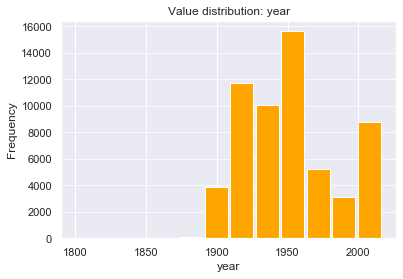

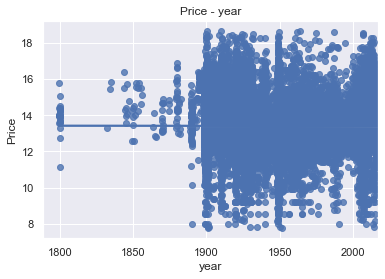

In [271]:
#17. Year built
df['year'] = df['YEAR BUILT']
#Impute median where year = 0
year_median = df['year'][df['year'] != 0].median()
#Date cannot before 1764
df['year'] = df['year'].apply(lambda x: x if x >= 1764 else year_median )
PlotHist(df['year'], 'orange')
PlotScatter(df['year'],'sns')

#Unclear if relationship between year and price

In [233]:
#18. Sale date
f = lambda x: str(x['SALE DATE']).split(' ')[0]
df['date']  = df.apply(f, axis=1)
sale_dates =  sorted(set(df['date']))

date_means = []
for i in sale_dates:
    date_means.append(np.exp(df['Price'][df['date']== i]).mean())
    
# plt.plot(sale_dates,date_means)
# plt.title('Price - Sale Date')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.show()
# # Apparently no clear relationship

In [272]:
#7 - Build regression model

Train = {}
Test = {}
model_no = 1

def RunRegression(model_number, model):
    print('Model no. ' + str([model_number]), "\n" )
    Train[model_number] = X_train[model]
    Test[model_number]= X_test[model]                        
    reg = LinearRegression().fit(Train[model_number], Y_train)
    score = reg.score(Test[model_number], Y_test)
    print('Model using variables: '+ str(list(Train[model_number])))
    print('R^2 Score: ' + str(score), "\n" )
    coefficients = reg.coef_
    print('Coefficients: ' +str(coefficients), "\n" )  
    global model_no
    model_no = model_number + 1

In [273]:
#6 - Split dataset into train and test

#potential features
# X= df[['BOROUGH','LOT','BLOCK', \
#        'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT',\
#        'TAX CLASS AT TIME OF SALE','res_unit_log','com_unit_log','tot_unit_log',\
#        'land_log','gross_sqft_log','year']]
X= df[['BOROUGH','LOT','BLOCK', \
       'bc',\
       'TAX CLASS AT TIME OF SALE','res_unit_log','com_unit_log','tot_unit_log',\
       'land_log','gross_sqft_log','year']]

Y = df['Price']
X_train, X_test, Y_train, Y_test = \
   train_test_split(X, Y, test_size=0.3, random_state=66)

In [274]:
#8 - Test and evaluate different models

#First model: only BOROUGH  
model =  ['BOROUGH']

RunRegression(model_no, model)

#Second model: BOROUGH and land  
model = ['BOROUGH','land_log']

RunRegression(model_no, model)
#Total R^2 increased

#Third model: BOROUGH and Gross_sqft  
model = ['BOROUGH',\
         'gross_sqft_log']
RunRegression(model_no, model)
#Total R^2 increased compared to land

#Fourth model: BOROUGH, Gross_sqft, Res_Unit 
model = ['BOROUGH',\
         'gross_sqft_log','res_unit_log']
RunRegression(model_no, model)
#Total R^2 not significantly increased

#Fifth model: BOROUGH, Gross_sqft, Com_Unit 
model = ['BOROUGH',\
         'gross_sqft_log','com_unit_log']
RunRegression(model_no, model)
#Total R^2 reduced

#Sixth model: BOROUGH, Gross_sqft, Tot_Unit 
model = ['BOROUGH',\
         'gross_sqft_log','tot_unit_log']
RunRegression(model_no, model)

#Total R^2 higher than res_units or com_units

#Seventh model: BOROUGH, Gross_sqft, Tot_Unit, TaxClass 
model = ['BOROUGH',\
         'gross_sqft_log','tot_unit_log']
RunRegression(model_no, model)
#Total R^2 slightly increased

#Next model: BOROUGH, Gross_sqft, Tot_Unit, TaxClass at Sale 
model = ['BOROUGH',\
         'gross_sqft_log','tot_unit_log','TAX CLASS AT TIME OF SALE']
RunRegression(model_no, model)
#Total R^2 slightly lower

#Next model: BOROUGH, Gross_sqft, Tot_Unit, TaxClass present, TaxClass at Sale 
model = ['BOROUGH',\
         'gross_sqft_log','tot_unit_log',\
         'TAX CLASS AT TIME OF SALE']
RunRegression(model_no, model)
#Total R^2 only slightly higher than without tax class at sale

#Next model: BOROUGH, Gross_sqft, Tot_Unit, TaxClass present, Building class
model = ['BOROUGH','LOT','BLOCK', \
       'bc',\
       'TAX CLASS AT TIME OF SALE','res_unit_log','com_unit_log','tot_unit_log',\
       'land_log','gross_sqft_log','year']
RunRegression(model_no, model)
#Total R^2 slightly increased

Model no. [1] 

Model using variables: ['BOROUGH']
R^2 Score: 0.11938063288011047 

Coefficients: [-0.26815421] 

Model no. [2] 

Model using variables: ['BOROUGH', 'land_log']
R^2 Score: 0.16126386236832513 

Coefficients: [-0.29171024  0.54734076] 

Model no. [3] 

Model using variables: ['BOROUGH', 'gross_sqft_log']
R^2 Score: 0.1967996206653294 

Coefficients: [-0.23252354  0.6101193 ] 

Model no. [4] 

Model using variables: ['BOROUGH', 'gross_sqft_log', 'res_unit_log']
R^2 Score: 0.2011110332932019 

Coefficients: [-0.24034506  0.51655768  0.14403856] 

Model no. [5] 

Model using variables: ['BOROUGH', 'gross_sqft_log', 'com_unit_log']
R^2 Score: 0.1983290066449397 

Coefficients: [-0.23342025  0.58151102  0.21246944] 

Model no. [6] 

Model using variables: ['BOROUGH', 'gross_sqft_log', 'tot_unit_log']
R^2 Score: 0.2032416245214993 

Coefficients: [-0.24332359  0.47447137  0.17895491] 

Model no. [7] 

Model using variables: ['BOROUGH', 'gross_sqft_log', 'tot_unit_log']
R^2 Sco

In [282]:
import pickle
file = open('../../data/model/model.pkl', 'rb')
model = pickle.load(file)
file.close()

In [288]:
y_hat=rf.predict(X_test)

In [289]:
y_hat

array([12.84913838, 12.62615076, 13.15699704, ..., 13.2579549 ,
       13.45745379, 12.15972622])

In [290]:
Y_test

26579    14.077875
80080    13.052640
32325    13.426903
68404    12.765688
20874    15.157138
           ...    
16203    13.693343
37711    10.165852
32616    13.049793
41297    13.805460
59822    11.603789
Name: Price, Length: 17565, dtype: float64

In [291]:
df_metric = pd.DataFrame(data={'R square': [r2_score(Y_test, y_hat)]})

In [292]:
df_metric 

,R square
0,0.662462


In [295]:
df_metric.to_csv("metric.txt",index=False)

In [198]:
error= abs(np.exp(y_hat)-np.exp(Y_test))

In [189]:
Y_test

77804    13.171154
42376    13.814510
56372    13.604790
9931     13.726679
83266    12.691580
           ...    
53280    13.199423
35743    12.741835
16589    13.458836
33352    13.910866
1899     14.690979
Name: Price, Length: 17268, dtype: float64

In [190]:
error

77804    0.583762
42376    1.069327
56372    0.483827
9931     1.515491
83266    0.420903
           ...   
53280    0.055694
35743    1.354424
16589    1.102722
33352    0.984825
1899     0.478277
Name: Price, Length: 17268, dtype: float64

In [193]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
# Update matplotlib defaults to something nicer
mpl_update = {
    'font.size': 16,
    'axes.prop_cycle': cycler('color', ['#0085ca', '#888b8d', '#00c389', '#f4364c', '#e56db1']),
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'figure.figsize': [12.0, 8.0],
    'axes.labelsize': 20,
    'axes.labelcolor': '#677385',
    'axes.titlesize': 20,
    'lines.color': '#0055A7',
    'lines.linewidth': 3,
    'text.color': '#677385',
    'font.family': 'sans-serif',
    'font.sans-serif': 'Tahoma'
}
mpl.rcParams.update(mpl_update)

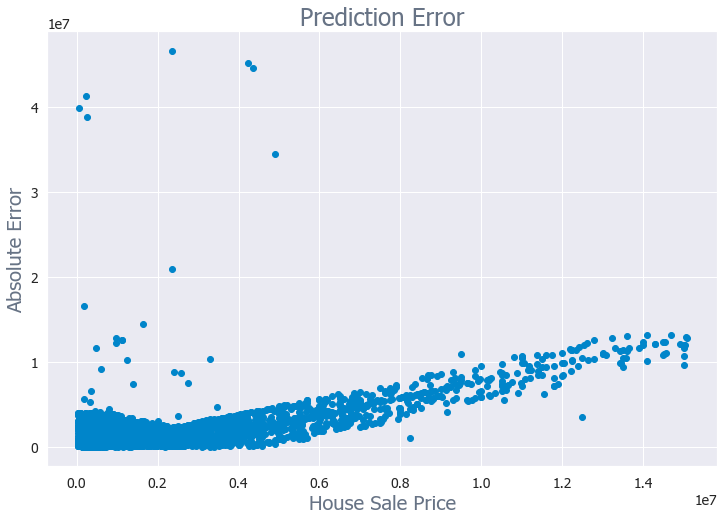

In [199]:
ax = plt.scatter(np.exp(Y_test),error)
plt.title('Prediction Error',fontsize=24)
plt.ylabel('Absolute Error')
plt.xlabel('House Sale Price')
ax.figure.savefig("123.png")

In [255]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 100, random_state = 66)

# Train the model on training data
rf.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=66, verbose=0, warm_start=False)

In [171]:
error

26579    1.329646
80080    0.211534
32325    1.134326
68404    0.176171
20874    1.987391
           ...   
16203    1.188362
37711    3.129941
32616    0.114756
41297    0.296041
59822    1.761317
Name: Price, Length: 17565, dtype: float64

In [281]:
# Use the forest's predict method on the test data
y_hat = rf.predict(X_test)
print('The R square:',r2_score(Y_test, y_hat))

The R square: 0.6624616715880267


In [85]:
SS_Residual = sum((Y_test-y_hat)**2)
SS_Total = sum((Y_test-np.mean(Y_test))**2)
r_squared = 1 - (float(SS_Residual))/SS_Total
adjusted_r_squared = 1 - (1-r_squared)*(len(Y_test)-1)/(len(Y_test)-X_test.shape[1]-1)
# adjusted R square
print('Adjusted R square:', adjusted_r_squared)

Adjusted R square: 0.6622501452613294


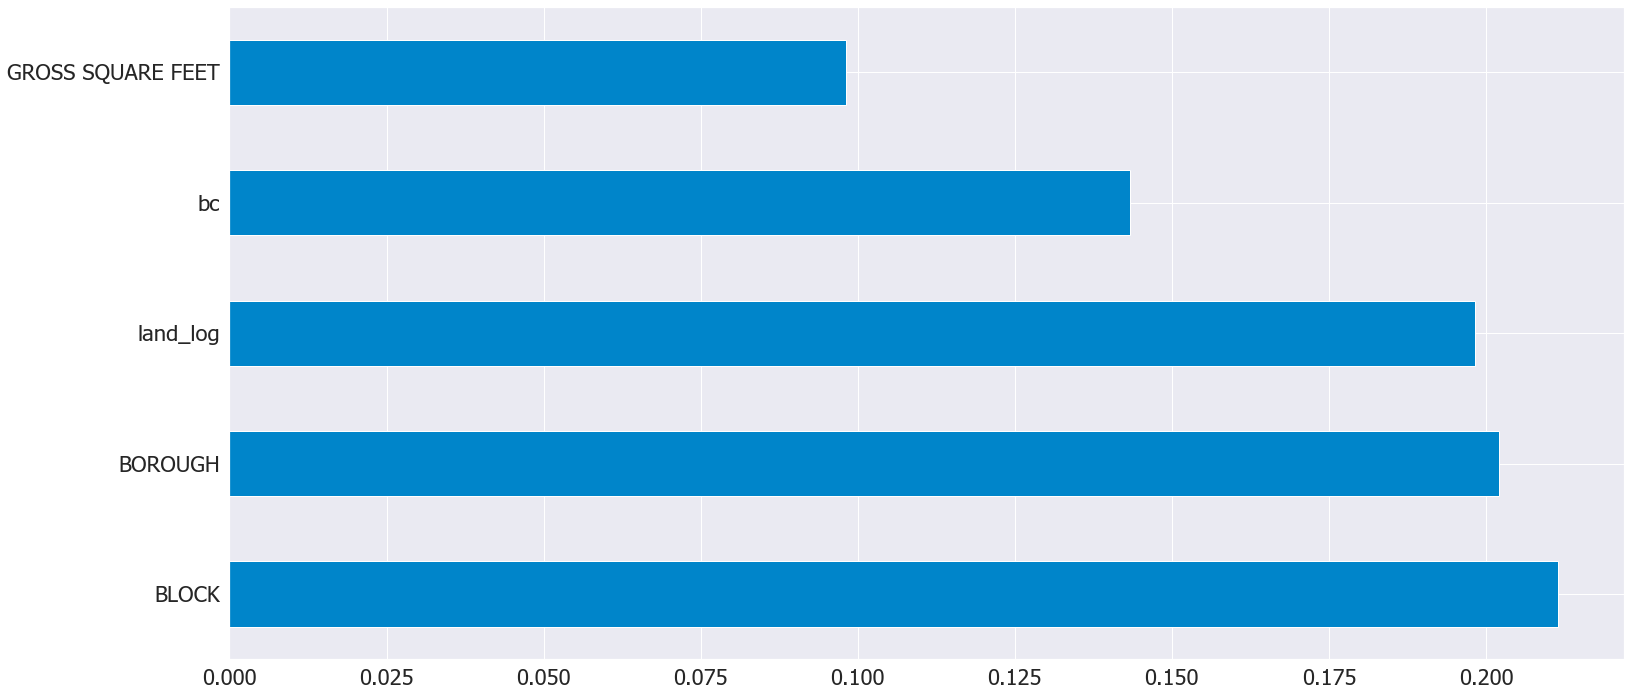

In [203]:
feat_importances = pd.Series(model.feature_importances_, index=['BOROUGH','LOT','BLOCK', \
       'bc','TAX CLASS AT TIME OF SALE','res_unit_log','com_unit_log','tot_unit_log',\
       'land_log','GROSS SQUARE FEET','YEAR BUILT'])
ax = feat_importances.nlargest(5).plot(kind='barh',figsize=(25,12),fontsize=22)
ax.figure.savefig("feature_importance.jpg")

In [87]:
error = abs(Y_test - y_hat)

In [88]:
error

26579    1.228736
80080    0.426489
32325    0.269906
68404    0.250927
20874    0.506245
           ...   
16203    0.005275
37711    1.084280
32616    0.208162
41297    0.348006
59822    0.555937
Name: Price, Length: 17565, dtype: float64

In [200]:
Y[Y.index == 83304]

83304    13.077366
Name: Price, dtype: float64

In [147]:
test = pd.DataFrame([[int(bo),int(lot),int(block),int(bc),int(tax),np.log(int(ru)),
                     np.log(int(cu)),np.log(int(tu)),np.log(float(land)),
                     np.log(float(gross)),int(yr)]],
                    columns=["BOROUGH","LOT","BLOCK","bc","TAX CLASS AT TIME OF SALE",
                             "res_unit_log","com_unit_log","tot_unit_log", "land_log", 
                             "gross_sqft_log","year"])